# Explore deblender data products

Get a footprint for an Object of interest and its children.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time

import lsst.daf.butler as butler

import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

### for the cutout_coadd function
import lsst.geom as geom

### for the heavyFootprintToImage function
from lsst.afw.image import MaskedImage

In [2]:
def heavyFootprintToImage(heavy, fill=np.nan, bbox=None, imageType=MaskedImage):
    """Create an image of a HeavyFootprint
    Parameters
    ----------
    heavy : `HeavyFootprint`
        The HeavyFootprint to insert into the image
    fill: number
        Number to fill the pixels in the image that are not
        contained in `heavy`.
    bbox : `Box2I`
        Bounding box of the output image.
    imageType : `type`
        This should be either a `MaskedImage` or `Image` and describes
        the type of the output image.
    Returns
    -------
    image : `lsst.afw.image.MaskedImage` or `lsst.afw.image.Image`
        An image defined by `bbox` and padded with `fill` that
        contains the projected flux in `heavy`.
    """
    if bbox is None:
        bbox = heavy.getBBox()
    image = imageType(bbox, dtype=heavy.getImageArray().dtype)
    image.set(fill)
    heavy.insert(image)
    return image

In [3]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

## Make deepCoadd cutout for parent Object of interest

In [4]:
butler = butler.Butler('dp02', collections='2.2i/runs/DP0.2')

In [5]:
tract = 2897
patch = 5
sel_objid = 1248675773246610542 
ra = 50.1089143
dec = -44.4812763
dataId = {'tract': tract, 'band': 'i', 'patch': patch }

In [6]:
my_cutout = cutout_coadd(butler, ra, dec, band='i', 
                         datasetType='deepCoadd', skymap=None, 
                         cutoutSideLength=101)

<Figure size 400x400 with 0 Axes>

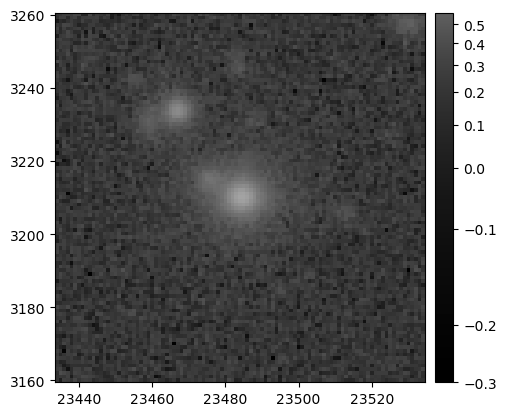

In [7]:
plt.figure(figsize=(4, 4))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.getImage())

## Retrieve children via butler, add to cutout

In [8]:
obj = butler.get('objectTable', dataId=dataId)

In [9]:
# obj

In [10]:
obj_parentObjectId = np.asarray(obj.parentObjectId, dtype='int')
obj_objectId = np.asarray(obj.index, dtype='int')
obj_coord_x = np.asarray(obj.x, dtype='float')
obj_coord_y = np.asarray(obj.y, dtype='float')

In [11]:
tx = np.where(obj_parentObjectId == sel_objid)[0]
for x in tx:
    print(obj_parentObjectId[x], obj_objectId[x], obj_coord_x[x], obj_coord_y[x])

1248675773246610542 1248675773246640703 23484.493982278047 3210.1595244834843
1248675773246610542 1248675773246640704 23466.9451451522 3233.6287998058606
1248675773246610542 1248675773246640705 23483.320008254163 3246.0487119002632
1248675773246610542 1248675773246640706 23512.9343388915 3205.7072499403953
1248675773246610542 1248675773246640707 23455.400666064994 3242.1856875225335
1248675773246610542 1248675773246640708 23488.07512761676 3231.692096689908
1248675773246610542 1248675773246640709 23459.093178291714 3230.9886405112957
1248675773246610542 1248675773246640710 23495.101275324098 3184.438564042999
1248675773246610542 1248675773246640711 23502.63552370019 3188.5572090849855
1248675773246610542 1248675773246640712 23465.71870790558 3197.3916488116315
1248675773246610542 1248675773246640713 23478.921981330524 3227.3238198632953
1248675773246610542 1248675773246640714 23503.206784555066 3201.591832926169
1248675773246610542 1248675773246640715 23463.005462370333 3244.5699979290

<Figure size 400x400 with 0 Axes>

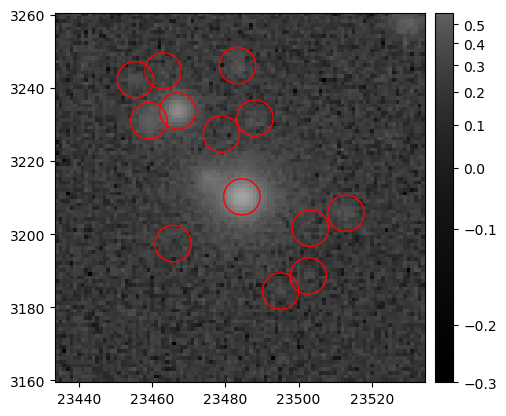

In [12]:
plt.figure(figsize=(4, 4))
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.getImage())

for x in tx:
    afw_display.dot('o', obj_coord_x[x], obj_coord_y[x], size=5, ctype=afwDisplay.RED)

## What deblender results are available in the butler?

In [13]:
registry = butler.registry
for dt in sorted(registry.queryDatasetTypes('*deblend*')):
    print(dt)

DatasetType('deblend_config', {}, Config)
DatasetType('deblend_log', {skymap, tract, patch}, ButlerLogRecords)
DatasetType('deblend_metadata', {skymap, tract, patch}, PropertySet)
DatasetType('deepCoadd_deblendedFlux', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedFlux_schema', {}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel', {band, skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_deblendedModel_schema', {}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_mcalmax_deblended_schema', {}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended', {skymap, tract, patch}, SourceCatalog)
DatasetType('deepCoadd_ngmix_deblended_schema', {}, SourceCatalog)


### Explore deepCoadd_deblendedFlux

In [14]:
dbFlux_schema = butler.get('deepCoadd_deblendedFlux_schema', dataId=dataId)

In [15]:
# for colname in dbFlux_schema.asAstropy().colnames:
#     print(colname)

In [16]:
dbFlux = butler.get('deepCoadd_deblendedFlux', dataId=dataId)

In [20]:
dbFlux_table = dbFlux.asAstropy()

In [21]:
#dbFlux_table

Use the `.getFootprint()` method to get the footprints for all records in `dbFlux`.

Add them to the Astropy table, and then a new columns 'footprint' will appear in the table.

In [22]:
footprints = [src.getFootprint() for src in dbFlux]
dbFlux_table["footprint"] = footprints

In [23]:
# dbFlux_table

First, explore a few columns of interest about the footprint.

In [24]:
dbFlux_id      = np.asarray(dbFlux_table['id'], dtype='int')
dbFlux_coord_x = np.asarray(dbFlux_table['deblend_peak_center_x'], dtype='float')
dbFlux_coord_y = np.asarray(dbFlux_table['deblend_peak_center_y'], dtype='float')
dbFlux_parent  = np.asarray(dbFlux_table['parent'], dtype='int')

In [25]:
tx = np.where(dbFlux_parent == sel_objid)[0]
for x in tx:
    print(dbFlux_parent[x], dbFlux_id[x], dbFlux_coord_x[x], dbFlux_coord_y[x])

1248675773246610542 1248675773246640703 23485.0 3210.0
1248675773246610542 1248675773246640704 23467.0 3234.0
1248675773246610542 1248675773246640705 23483.0 3246.0
1248675773246610542 1248675773246640706 23513.0 3206.0
1248675773246610542 1248675773246640707 23455.0 3242.0
1248675773246610542 1248675773246640708 23488.0 3231.0
1248675773246610542 1248675773246640709 23459.0 3231.0
1248675773246610542 1248675773246640710 23495.0 3185.0
1248675773246610542 1248675773246640711 23502.0 3188.0
1248675773246610542 1248675773246640712 23466.0 3198.0
1248675773246610542 1248675773246640713 23479.0 3227.0
1248675773246610542 1248675773246640714 23503.0 3202.0
1248675773246610542 1248675773246640715 23463.0 3244.0


In [26]:
dbFlux_merge_footprint_i     = np.asarray(dbFlux_table['merge_footprint_i'])
dbFlux_deblend_peak_instFlux = np.asarray(dbFlux_table['deblend_peak_instFlux'])
dbFlux_deblend_modelType     = np.asarray(dbFlux_table['deblend_modelType'])
dbFlux_deblend_scarletFlux   = np.asarray(dbFlux_table['deblend_scarletFlux'])

In [27]:
tx = np.where(dbFlux_parent == sel_objid)[0]
for x in tx:
    print(dbFlux_merge_footprint_i[x], dbFlux_deblend_peak_instFlux[x], 
          dbFlux_deblend_modelType[x], dbFlux_deblend_scarletFlux[x])

True 5.39021635055542 MultiExtendedSource 490.87234
True 2.3927512168884277 MultiExtendedSource 106.880486
True 0.33462783694267273 CompactExtendedSource 12.085948
True 0.3295254409313202 CompactExtendedSource 12.935391
True 0.26085060834884644 CompactExtendedSource 5.9582796
True 0.24051915109157562 CompactExtendedSource 10.048364
True 0.3871551752090454 CompactExtendedSource 22.802235
True 0.1430944949388504 CompactExtendedSource 3.7953627
True 0.11195013672113419 CompactExtendedSource 2.7816982
True 0.02966391295194626 CompactExtendedSource 1.5007979
True 1.6886492347454422e-21 CompactExtendedSource 4.1422963e-20
True 0.08955945819616318 CompactExtendedSource 2.5225735
True 0.14773274958133698 CompactExtendedSource 4.0033736


<br>

Now display the footprint for the first child of our object of interest.

Use the `heavyFootprintToImage` function to display as an image.

In [28]:
dbFlux_table['footprint'][tx[0]]

1 peaks, area=5840, centroid=(23484.5, 3217.97)

In [29]:
test0 = heavyFootprintToImage(dbFlux_table['footprint'][tx[0]])

In [30]:
test0

lsst.afw.image.maskedImage.MaskedImageF=(image=[[-6.4138042e-08  1.5352930e-07  4.3212890e-07 ...  1.2477750e-07
  -1.1122652e-07  5.6286957e-08]
 [-1.3667503e-07  3.0465245e-07  1.1550165e-06 ...  1.0772975e-07
  -4.0835477e-08  5.0206655e-08]
 [-2.2591514e-07  8.4675293e-07  1.6479391e-06 ...  3.4492592e-07
  -1.9184006e-07  1.1158906e-07]
 ...
 [ 8.7909120e-09 -1.3519552e-08  1.4409360e-08 ... -1.3127590e-08
   7.0429724e-09 -3.5920000e-09]
 [-4.4929092e-09  6.9000512e-09 -7.3862712e-09 ...  6.6887562e-09
  -3.5873546e-09  1.8299395e-09]
 [ 2.2813247e-09 -3.5022829e-09  3.7444328e-09 ... -3.3885725e-09
   1.8161397e-09 -9.2643804e-10]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'CLIPPED': 9, 'CR': 3, 'CROSSTALK': 10, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INEXACT_PSF': 11, 'INTRP': 2, 'NOT_DEBLENDED': 12, 'NO_DATA': 8, 'REJECTED': 13, 'SAT': 1, 'SENSOR_EDGE': 14, 

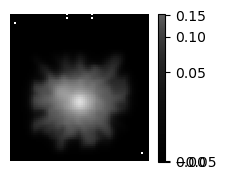

In [31]:
fig = plt.figure(figsize=(2, 2))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(test0)
plt.axis('off')
plt.show()

Not yet sure how to overplot or co-plot multiple footprints together...

E.g., as a multi-axis plot can show the first four, but this is **NOT WORKING RIGHT** but can fix / figure it out later.

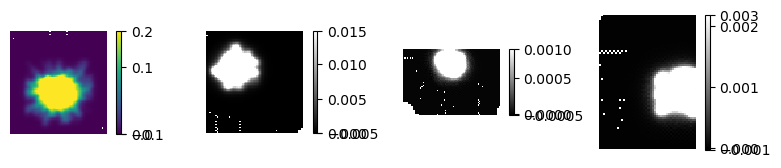

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(8, 4))

test0 = heavyFootprintToImage(dbFlux_table['footprint'][tx[0]])
plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.setImageColormap('viridis')
display0.scale('linear', 'zscale')
display0.mtv(test0)
ax[0].axis('off')

test1 = heavyFootprintToImage(dbFlux_table['footprint'][tx[1]])
plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(test1)
ax[1].axis('off')

test2 = heavyFootprintToImage(dbFlux_table['footprint'][tx[2]])
plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(test2)
ax[2].axis('off')

test3 = heavyFootprintToImage(dbFlux_table['footprint'][tx[3]])
plt.sca(ax[3])
display3 = afwDisplay.Display(frame=fig)
display3.scale('linear', 'zscale')
display3.mtv(test3)
ax[3].axis('off')

plt.tight_layout()
plt.show()

### Explore deepCoadd_deblendedModel

Is empty, or at least does not work with our dataId.

In [ ]:
# dbModel_schema = butler.get('deepCoadd_deblendedModel_schema', dataId=dataId)

In [ ]:
# dbModel = butler.get('deepCoadd_deblendedModel', dataId=dataId)